# Imports et lecture des données

## Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import mplfinance as mpl
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.linear_model import LinearRegression

In [2]:
sns.set_theme()

## Lecture des données

In [3]:
data_folder = "../data"

In [4]:
stock_name = "AAPL"

In [5]:
df = pd.read_csv(
    f"{data_folder}/{stock_name}.csv", parse_dates=["Date"], index_col="Date"
)
print(f"{df.shape = }")

df.shape = (756, 6)


# Soustraction de la tendance

La tendance est, pour une série chronologique, sa composante première, inhérente à la nature des données. Elle peut le plus souvent se représenter par une droite, à la hausse ou à la baisse. Dans le cas des cours boursiers, le prix a une tendance généralement haussière, qui s'explique par le concept de croissance économique.

<Axes: title={'center': 'Closing price plot (daily) with trend'}, xlabel='Date'>

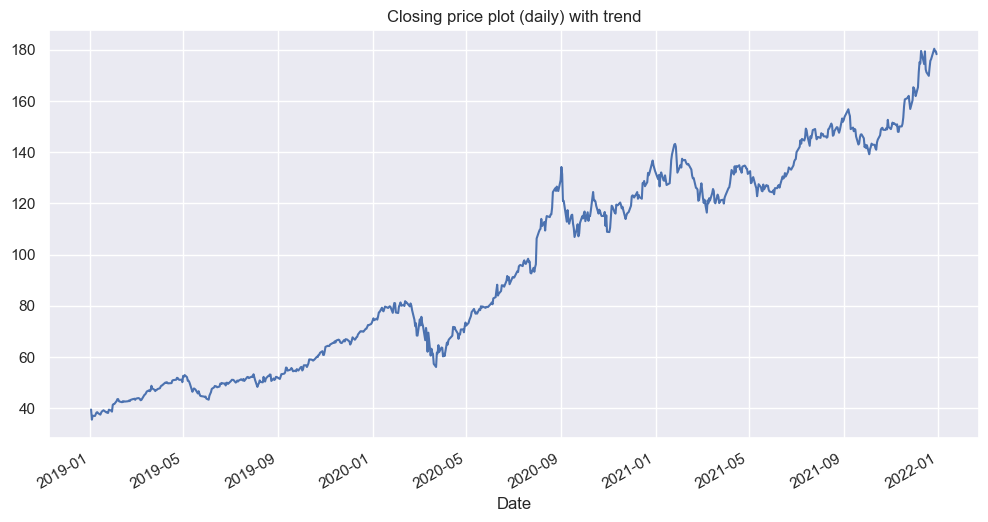

In [6]:
df["Close"].plot(title="Closing price plot (daily) with trend", figsize=(12, 6))

## Régression linéaire

Soit le vecteur $Y = (y_1, \dots, y_N)$ des prix de clôture du cours aux temps (ici, des jours) $1, \dots, N$.  

L'objectif est de s'ajuster aux données avec un modèle de régression linéaire simple donné par l'équation :
$$ Y = \beta_0 + \beta_1 * X$$
où $(\beta_0, \beta_1)$ est le vecteur des paramètres à estimer  
et $X = (1, \dots, N)$ est le vecteur <i>time dummy</i> qui représente l'avancement linéaire du temps.  

Puis il faut soustraire au vecteur de données originales $Y$ le vecteur des prédictions $Y_{pred}$ :
$$y_{detrend_i} = y_i - y_{pred_i} \hspace{12px} \forall i \in [1;N]$$ 

In [7]:
# Create deterministic process (X)

dp = DeterministicProcess(
    index=df.index,  # dates from the training data
    constant=True,  # dummy feature for the bias (y_intercept)
    order=1,  # order of the time dummy (trend)
    drop=False,  # drop terms if necessary to avoid collinearity
)

# `in_sample` creates features for the dates given in the `index` argument
X_dp = dp.in_sample()

X_dp

,const,trend
Date,,
2019-01-02,1.0,1.0
2019-01-03,1.0,2.0
2019-01-04,1.0,3.0
2019-01-07,1.0,4.0
2019-01-08,1.0,5.0
...,...,...
2021-12-23,1.0,752.0
2021-12-27,1.0,753.0
2021-12-28,1.0,754.0


In [8]:
# Convert data and fit the linear regression

X = np.array(X_dp)
y = np.array(df["Close"])

model = LinearRegression()
model.fit(X, y)

y_predict = model.predict(X)

Text(0.5, 1.0, 'Closing price plot and trend')

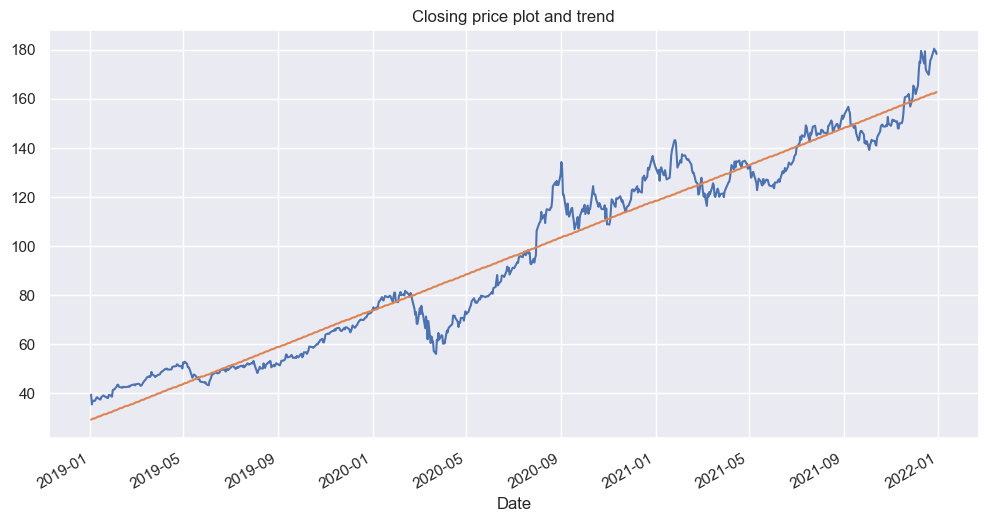

In [9]:
# Plot data and trend

_, ax = plt.subplots(figsize=(12, 6))

df["Close"].plot(ax=ax)
plt.plot(X_dp.index, y_predict)
plt.title("Closing price and trend plot")

<Axes: title={'center': 'Closing price without trend'}, xlabel='Date'>

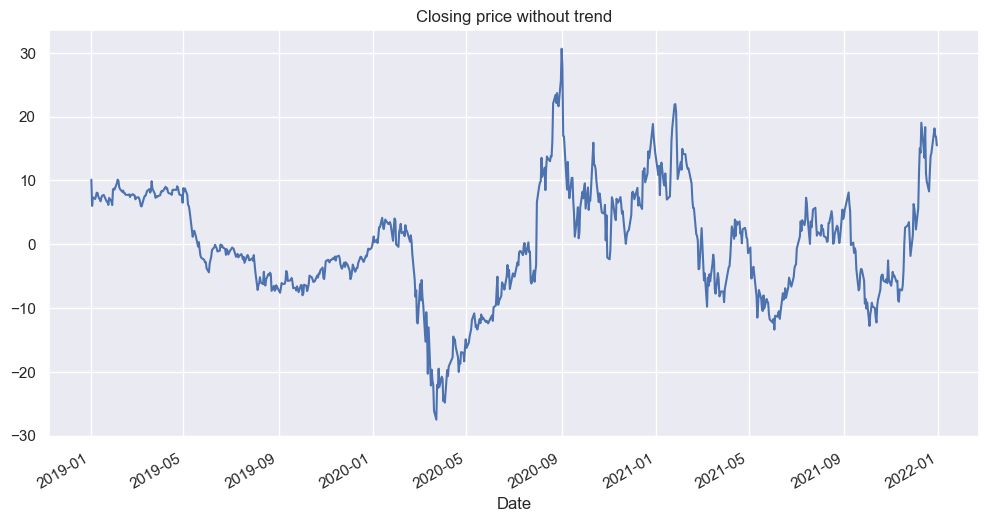

In [10]:
# substract the trend from the original times series

df["Close_detrend"] = df["Close"] - y_predict
df["Close_detrend"].plot(title="Closing price without trend", figsize=(12, 6))

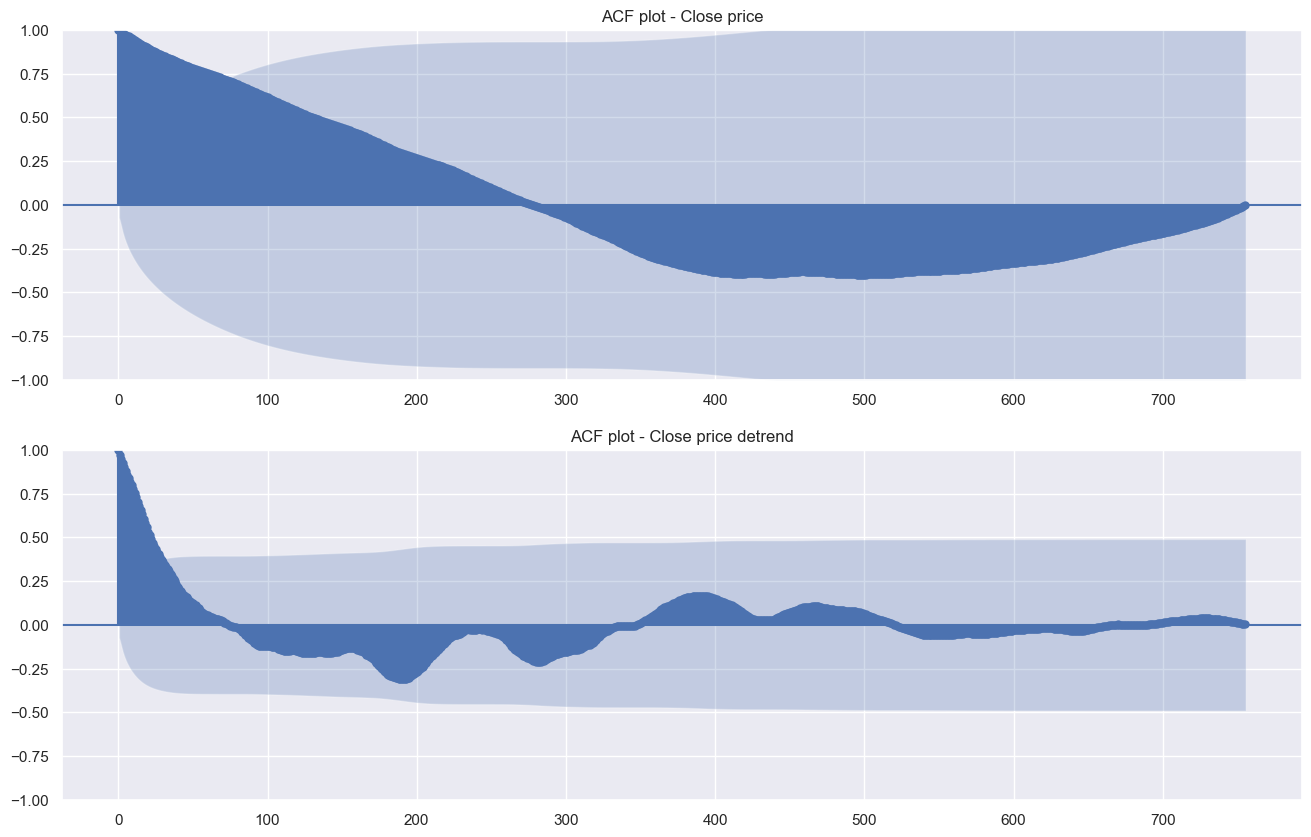

In [11]:
# acf plot before / after

lag = len(df) - 1

_, axs = plt.subplots(2, 1, figsize=(16, 10))
_ = plot_acf(df["Close"], ax=axs[0], lags=lag, title="ACF plot - Close price")
_ = plot_acf(
    df["Close_detrend"], ax=axs[1], lags=lag, title="ACF plot - Close price detrend"
)

- Les fortes autocorrélations dans le premier graphique montrent que la série temporelle contient une <b>tendance</b>.  
- Après déconstruction de la tendance, le deuxième graphique affiche cependant encore des autocorrélations importantes <b>pour des lags petits</b>. C'est un indice de <b>saisonnalité</b> ou de <b>cyclicité</b>. 

## Régression polynomiale par morceaux

Soit $k \in N^*$.  
Pour la régression polynomiale d'ordre $k$, le même principe que la régression linéaire simple est appliqué mais avec la particularité que des <i>time dummies</i> d'ordre $1, \dots, k$ sont ajoutées comme variables explicatives au modèle.  
L'équation de régression devient :
$$ Y = \sum_{i=0}^{k} \beta_i * X_i$$
où pour tout $i \in [1;k], \hspace{6px} X_i = (1^i, 2^i, \dots, N^i)$.
 
Cette méthode permet de capter une tendance polynomiale (croissante au carré du temps par exemple).